In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.simplefilter('ignore')
import math
from statistics import mean
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.metrics import mean_squared_error


#from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

In [2]:
from sklearn.model_selection import train_test_split
import category_encoders as ce

In [3]:
status = pd.read_csv('../../../status.csv')
trip = pd.read_csv('../../../trip.csv')
station = pd.read_csv('../../../station.csv')
weather = pd.read_csv('../../../weather.csv')

In [4]:
status

,id,year,month,day,hour,station_id,bikes_available,predict
0,0,2013,9,1,0,0,11.0,0
1,1,2013,9,1,1,0,11.0,0
2,2,2013,9,1,2,0,11.0,0
3,3,2013,9,1,3,0,11.0,0
4,4,2013,9,1,4,0,11.0,0
...,...,...,...,...,...,...,...,...
1226395,1226395,2015,8,31,19,69,8.0,0
1226396,1226396,2015,8,31,20,69,8.0,0
1226397,1226397,2015,8,31,21,69,8.0,0
1226398,1226398,2015,8,31,22,69,8.0,0


In [5]:
#statusのyear, month, dayを結合してdatetime型に
status['date'] = status['year'].astype(str) + '/' + status['month'].astype(str).str.zfill(2).astype(str) + '/' + status['day'].astype(str).str.zfill(2).astype(str) + '/' + status['hour'].astype(str).str.zfill(2).astype(str)
status['date'] = pd.to_datetime(status['date'], format='%Y/%m/%d/%H', infer_datetime_format=True)

#statusにstationのcityをマージ
status = pd.merge(status, station[['station_id', 'city']], how = 'left')

In [6]:
#曜日を追加するための関数を定義
def get_weekday_jp(dt):
    w_list = ['月曜日', '火曜日', '水曜日', '木曜日', '金曜日', '土曜日', '日曜日']
    return(w_list[dt.weekday()])

#dateから曜日情報を取得
status["weekday"] = status["date"].apply(get_weekday_jp)
status.head(10)

,id,year,month,day,hour,station_id,bikes_available,predict,date,city,weekday
0,0,2013,9,1,0,0,11.0,0,2013-09-01 00:00:00,city1,日曜日
1,1,2013,9,1,1,0,11.0,0,2013-09-01 01:00:00,city1,日曜日
2,2,2013,9,1,2,0,11.0,0,2013-09-01 02:00:00,city1,日曜日
3,3,2013,9,1,3,0,11.0,0,2013-09-01 03:00:00,city1,日曜日
4,4,2013,9,1,4,0,11.0,0,2013-09-01 04:00:00,city1,日曜日
5,5,2013,9,1,5,0,11.0,0,2013-09-01 05:00:00,city1,日曜日
6,6,2013,9,1,6,0,11.0,0,2013-09-01 06:00:00,city1,日曜日
7,7,2013,9,1,7,0,11.0,0,2013-09-01 07:00:00,city1,日曜日
8,8,2013,9,1,8,0,11.0,0,2013-09-01 08:00:00,city1,日曜日
9,9,2013,9,1,9,0,11.0,0,2013-09-01 09:00:00,city1,日曜日


In [7]:
status

,id,year,month,day,hour,station_id,bikes_available,predict,date,city,weekday
0,0,2013,9,1,0,0,11.0,0,2013-09-01 00:00:00,city1,日曜日
1,1,2013,9,1,1,0,11.0,0,2013-09-01 01:00:00,city1,日曜日
2,2,2013,9,1,2,0,11.0,0,2013-09-01 02:00:00,city1,日曜日
3,3,2013,9,1,3,0,11.0,0,2013-09-01 03:00:00,city1,日曜日
4,4,2013,9,1,4,0,11.0,0,2013-09-01 04:00:00,city1,日曜日
...,...,...,...,...,...,...,...,...,...,...,...
1226395,1226395,2015,8,31,19,69,8.0,0,2015-08-31 19:00:00,city1,月曜日
1226396,1226396,2015,8,31,20,69,8.0,0,2015-08-31 20:00:00,city1,月曜日
1226397,1226397,2015,8,31,21,69,8.0,0,2015-08-31 21:00:00,city1,月曜日
1226398,1226398,2015,8,31,22,69,8.0,0,2015-08-31 22:00:00,city1,月曜日


In [8]:
main_df = status[['date','hour', 'station_id', 'bikes_available', 'weekday', 'predict']]
main_df

,date,hour,station_id,bikes_available,weekday,predict
0,2013-09-01 00:00:00,0,0,11.0,日曜日,0
1,2013-09-01 01:00:00,1,0,11.0,日曜日,0
2,2013-09-01 02:00:00,2,0,11.0,日曜日,0
3,2013-09-01 03:00:00,3,0,11.0,日曜日,0
4,2013-09-01 04:00:00,4,0,11.0,日曜日,0
...,...,...,...,...,...,...
1226395,2015-08-31 19:00:00,19,69,8.0,月曜日,0
1226396,2015-08-31 20:00:00,20,69,8.0,月曜日,0
1226397,2015-08-31 21:00:00,21,69,8.0,月曜日,0
1226398,2015-08-31 22:00:00,22,69,8.0,月曜日,0


In [9]:
#カテゴリ変数をダミー変数化
main_df = pd.get_dummies(main_df)
print(main_df.columns)
print(main_df.shape)

Index(['date', 'hour', 'station_id', 'bikes_available', 'predict',
       'weekday_土曜日', 'weekday_日曜日', 'weekday_月曜日', 'weekday_木曜日',
       'weekday_水曜日', 'weekday_火曜日', 'weekday_金曜日'],
      dtype='object')
(1226400, 12)


In [10]:
main_df

,date,hour,station_id,bikes_available,predict,weekday_土曜日,weekday_日曜日,weekday_月曜日,weekday_木曜日,weekday_水曜日,weekday_火曜日,weekday_金曜日
0,2013-09-01 00:00:00,0,0,11.0,0,0,1,0,0,0,0,0
1,2013-09-01 01:00:00,1,0,11.0,0,0,1,0,0,0,0,0
2,2013-09-01 02:00:00,2,0,11.0,0,0,1,0,0,0,0,0
3,2013-09-01 03:00:00,3,0,11.0,0,0,1,0,0,0,0,0
4,2013-09-01 04:00:00,4,0,11.0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1226395,2015-08-31 19:00:00,19,69,8.0,0,0,0,1,0,0,0,0
1226396,2015-08-31 20:00:00,20,69,8.0,0,0,0,1,0,0,0,0
1226397,2015-08-31 21:00:00,21,69,8.0,0,0,0,1,0,0,0,0
1226398,2015-08-31 22:00:00,22,69,8.0,0,0,0,1,0,0,0,0


In [11]:
train = main_df[main_df['date'] >= '2013-10-01']
train = train[train['date'] < '2013-11-01']
train = train[train['station_id'] == 0] 
train

,date,hour,station_id,bikes_available,predict,weekday_土曜日,weekday_日曜日,weekday_月曜日,weekday_木曜日,weekday_水曜日,weekday_火曜日,weekday_金曜日
720,2013-10-01 00:00:00,0,0,16.0,0,0,0,0,0,0,1,0
721,2013-10-01 01:00:00,1,0,14.0,0,0,0,0,0,0,1,0
722,2013-10-01 02:00:00,2,0,14.0,0,0,0,0,0,0,1,0
723,2013-10-01 03:00:00,3,0,14.0,0,0,0,0,0,0,1,0
724,2013-10-01 04:00:00,4,0,14.0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1459,2013-10-31 19:00:00,19,0,19.0,0,0,0,0,1,0,0,0
1460,2013-10-31 20:00:00,20,0,18.0,0,0,0,0,1,0,0,0
1461,2013-10-31 21:00:00,21,0,18.0,0,0,0,0,1,0,0,0
1462,2013-10-31 22:00:00,22,0,18.0,0,0,0,0,1,0,0,0


In [12]:
test = main_df[main_df['date'] >= '2013-11-01']
test = test[test['date'] < '2013-11-08']
test = test[test['station_id'] == 0] 
test

,date,hour,station_id,bikes_available,predict,weekday_土曜日,weekday_日曜日,weekday_月曜日,weekday_木曜日,weekday_水曜日,weekday_火曜日,weekday_金曜日
1464,2013-11-01 00:00:00,0,0,17.0,0,0,0,0,0,0,0,1
1465,2013-11-01 01:00:00,1,0,16.0,0,0,0,0,0,0,0,1
1466,2013-11-01 02:00:00,2,0,16.0,0,0,0,0,0,0,0,1
1467,2013-11-01 03:00:00,3,0,16.0,0,0,0,0,0,0,0,1
1468,2013-11-01 04:00:00,4,0,16.0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1627,2013-11-07 19:00:00,19,0,18.0,0,0,0,0,1,0,0,0
1628,2013-11-07 20:00:00,20,0,16.0,0,0,0,0,1,0,0,0
1629,2013-11-07 21:00:00,21,0,16.0,0,0,0,0,1,0,0,0
1630,2013-11-07 22:00:00,22,0,16.0,0,0,0,0,1,0,0,0


In [13]:
#学習用データの欠損値を確認
print(train.isnull().sum())

date               0
hour               0
station_id         0
bikes_available    0
predict            0
weekday_土曜日        0
weekday_日曜日        0
weekday_月曜日        0
weekday_木曜日        0
weekday_水曜日        0
weekday_火曜日        0
weekday_金曜日        0
dtype: int64


In [14]:
#predictは特徴量として必要ないため、削除
train = train.drop("predict",axis=1)
train

,date,hour,station_id,bikes_available,weekday_土曜日,weekday_日曜日,weekday_月曜日,weekday_木曜日,weekday_水曜日,weekday_火曜日,weekday_金曜日
720,2013-10-01 00:00:00,0,0,16.0,0,0,0,0,0,1,0
721,2013-10-01 01:00:00,1,0,14.0,0,0,0,0,0,1,0
722,2013-10-01 02:00:00,2,0,14.0,0,0,0,0,0,1,0
723,2013-10-01 03:00:00,3,0,14.0,0,0,0,0,0,1,0
724,2013-10-01 04:00:00,4,0,14.0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1459,2013-10-31 19:00:00,19,0,19.0,0,0,0,1,0,0,0
1460,2013-10-31 20:00:00,20,0,18.0,0,0,0,1,0,0,0
1461,2013-10-31 21:00:00,21,0,18.0,0,0,0,1,0,0,0
1462,2013-10-31 22:00:00,22,0,18.0,0,0,0,1,0,0,0


In [54]:
#今回LSTMモデルを使用するため、データを標準化
#特徴量を標準化するための変数
scaler = MinMaxScaler(feature_range=(0, 1))
#標準化された出力をもとにスケールに変換(inverse)するために必要な変数
scaler_for_inverse = MinMaxScaler(feature_range=(0, 1))
train_df_scale = scaler.fit_transform(train.iloc[:,3:])
bikes_available_scale = scaler_for_inverse.fit_transform(train[["bikes_available"]])
print(train_df_scale.shape)

In [50]:
train_df_scale[0]

array([0.63157895, 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        ])

In [16]:
length = len(train_df_scale)
train_size = int(length)
train = train_df_scale[0:train_size,:]
print(train.shape)

(744, 8)


In [17]:
def create_dataset(dataset):
    dataX = []
    dataY = np.array([])
    #1680で1つのデータセットであるため、余りの分は使わない
    
    max_len = len(dataset)
    for i in range(24,max_len,1):
        xset = []
        for j in range(dataset.shape[1]):
            a = dataset[i-24:i, j]
            xset.append(a)
        temp_array = np.array(dataset[i:i+1,0])
        dataY = np.concatenate([dataY,temp_array])
        dataX.append(xset)
    dataY = dataY.reshape(-1,1)
    return np.array(dataX), dataY 

In [18]:
trainX, trainY = create_dataset(train)

In [19]:
trainX[0]

array([[0.63157895, 0.52631579, 0.52631579, 0.52631579, 0.52631579,
        0.52631579, 0.57894737, 0.63157895, 0.57894737, 0.36842105,
        0.26315789, 0.26315789, 0.26315789, 0.26315789, 0.26315789,
        0.26315789, 0.26315789, 0.52631579, 0.68421053, 0.63157895,
        0.57894737, 0.57894737, 0.57894737, 0.63157895],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        ],
       [0.   

In [20]:
trainY

array([[0.57894737],
       [0.57894737],
       [0.57894737],
       [0.57894737],
       [0.57894737],
       [0.57894737],
       [0.57894737],
       [0.57894737],
       [0.42105263],
       [0.26315789],
       [0.05263158],
       [0.52631579],
       [0.52631579],
       [0.57894737],
       [0.57894737],
       [0.57894737],
       [0.57894737],
       [0.68421053],
       [0.89473684],
       [0.73684211],
       [0.73684211],
       [0.73684211],
       [0.78947368],
       [0.78947368],
       [0.78947368],
       [0.78947368],
       [0.73684211],
       [0.78947368],
       [0.78947368],
       [0.78947368],
       [0.78947368],
       [0.84210526],
       [0.63157895],
       [0.47368421],
       [0.42105263],
       [0.31578947],
       [0.47368421],
       [0.47368421],
       [0.47368421],
       [0.47368421],
       [0.47368421],
       [0.68421053],
       [0.73684211],
       [0.68421053],
       [0.68421053],
       [0.57894737],
       [0.57894737],
       [0.578

In [21]:
#LSTMのモデルに入力用にデータの形を整形
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], trainX.shape[2]))
#入力データと正解データの形を確認
print(trainX.shape)
print(trainY.shape)

(720, 8, 24)
(720, 1)


In [22]:
model = Sequential()
model.add(LSTM(50, input_shape=(trainX.shape[1],24)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                15000     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 15,051
Trainable params: 15,051
Non-trainable params: 0
_________________________________________________________________


In [23]:
hist = model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
720/720 - 2s - loss: 0.0257
Epoch 2/20
720/720 - 1s - loss: 0.0154
Epoch 3/20
720/720 - 1s - loss: 0.0119
Epoch 4/20
720/720 - 1s - loss: 0.0096
Epoch 5/20
720/720 - 1s - loss: 0.0085
Epoch 6/20
720/720 - 1s - loss: 0.0069
Epoch 7/20
720/720 - 1s - loss: 0.0067
Epoch 8/20
720/720 - 1s - loss: 0.0066
Epoch 9/20
720/720 - 1s - loss: 0.0065
Epoch 10/20
720/720 - 1s - loss: 0.0064
Epoch 11/20
720/720 - 1s - loss: 0.0064
Epoch 12/20
720/720 - 1s - loss: 0.0057
Epoch 13/20
720/720 - 1s - loss: 0.0060
Epoch 14/20
720/720 - 1s - loss: 0.0055
Epoch 15/20
720/720 - 1s - loss: 0.0056
Epoch 16/20
720/720 - 1s - loss: 0.0052
Epoch 17/20
720/720 - 1s - loss: 0.0056
Epoch 18/20
720/720 - 1s - loss: 0.0050
Epoch 19/20
720/720 - 1s - loss: 0.0051
Epoch 20/20
720/720 - 1s - loss: 0.0049


In [24]:
#学習済みモデルで予測
train_predict = model.predict(trainX)
#test_predict = model.predict(testX)

#スケールをもとに戻す
train_predict = scaler_for_inverse.inverse_transform(train_predict)
trainY = scaler_for_inverse.inverse_transform(trainY)
#test_predict = scaler_for_inverse.inverse_transform(test_predict)
#testY = scaler_for_inverse.inverse_transform(testY)

#各ステーションのスコアの平均値を算出
train_score_list = []
#test_score_list = []

trainscore = math.sqrt(mean_squared_error(trainY[:,0], train_predict[:,0]))
train_score_list.append(trainscore)
#    testscore = math.sqrt(mean_squared_error(testY[:,i], test_predict[:,i]))
#    test_score_list.append(testscore)
    
print("trainのRMSE平均 : ",mean(train_score_list))
#print("testのRMSE平均 : ",mean(test_score_list))

trainのRMSE平均 :  1.1064350375804979


In [45]:
trainX

array([[[0.63157895, 0.52631579, 0.52631579, ..., 0.57894737,
         0.57894737, 0.63157895],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.52631579, 0.52631579, 0.52631579, ..., 0.57894737,
         0.63157895, 0.57894737],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 1.        ],
        [1. 

In [25]:
train_predict

array([[15.2323065],
       [14.684439 ],
       [14.1572895],
       [14.335437 ],
       [14.743062 ],
       [15.015864 ],
       [15.427234 ],
       [15.15772  ],
       [12.959671 ],
       [ 9.673141 ],
       [ 9.350384 ],
       [ 9.352186 ],
       [11.654142 ],
       [12.496312 ],
       [13.397989 ],
       [14.176259 ],
       [14.68807  ],
       [17.687578 ],
       [19.487923 ],
       [19.821856 ],
       [17.700563 ],
       [17.934517 ],
       [18.61892  ],
       [18.962406 ],
       [18.683817 ],
       [19.569117 ],
       [18.643644 ],
       [18.689867 ],
       [19.12138  ],
       [19.477629 ],
       [19.471289 ],
       [19.776861 ],
       [17.882265 ],
       [13.336431 ],
       [11.8116   ],
       [12.27036  ],
       [11.594636 ],
       [12.453451 ],
       [13.28138  ],
       [12.886477 ],
       [13.604531 ],
       [16.371954 ],
       [18.799826 ],
       [18.365997 ],
       [17.355171 ],
       [17.34293  ],
       [16.018719 ],
       [15.74

In [26]:
trainY

array([[15.],
       [15.],
       [15.],
       [15.],
       [15.],
       [15.],
       [15.],
       [15.],
       [12.],
       [ 9.],
       [ 5.],
       [14.],
       [14.],
       [15.],
       [15.],
       [15.],
       [15.],
       [17.],
       [21.],
       [18.],
       [18.],
       [18.],
       [19.],
       [19.],
       [19.],
       [19.],
       [18.],
       [19.],
       [19.],
       [19.],
       [19.],
       [20.],
       [16.],
       [13.],
       [12.],
       [10.],
       [13.],
       [13.],
       [13.],
       [13.],
       [13.],
       [17.],
       [18.],
       [17.],
       [17.],
       [15.],
       [15.],
       [15.],
       [15.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [14.],
       [15.],
       [13.],
       [ 7.],
       [ 6.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [10.],
       [12.],
       [18.],
       [16.],
       [15.],
       [15.],
       [15.],
      

In [27]:
train_df = main_df[main_df['date'] >= '2013-10-01']
train_df = train_df[train_df['date'] < '2013-11-01']
train_df = train_df[train_df['station_id'] == 0] 
train_df

,date,hour,station_id,bikes_available,predict,weekday_土曜日,weekday_日曜日,weekday_月曜日,weekday_木曜日,weekday_水曜日,weekday_火曜日,weekday_金曜日
720,2013-10-01 00:00:00,0,0,16.0,0,0,0,0,0,0,1,0
721,2013-10-01 01:00:00,1,0,14.0,0,0,0,0,0,0,1,0
722,2013-10-01 02:00:00,2,0,14.0,0,0,0,0,0,0,1,0
723,2013-10-01 03:00:00,3,0,14.0,0,0,0,0,0,0,1,0
724,2013-10-01 04:00:00,4,0,14.0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1459,2013-10-31 19:00:00,19,0,19.0,0,0,0,0,1,0,0,0
1460,2013-10-31 20:00:00,20,0,18.0,0,0,0,0,1,0,0,0
1461,2013-10-31 21:00:00,21,0,18.0,0,0,0,0,1,0,0,0
1462,2013-10-31 22:00:00,22,0,18.0,0,0,0,0,1,0,0,0


In [28]:
array = []
for i in train_predict:
    array.append(i[0])
array

[15.2323065,
 14.684439,
 14.1572895,
 14.335437,
 14.743062,
 15.015864,
 15.427234,
 15.15772,
 12.959671,
 9.673141,
 9.350384,
 9.352186,
 11.654142,
 12.496312,
 13.397989,
 14.176259,
 14.68807,
 17.687578,
 19.487923,
 19.821856,
 17.700563,
 17.934517,
 18.61892,
 18.962406,
 18.683817,
 19.569117,
 18.643644,
 18.689867,
 19.12138,
 19.477629,
 19.471289,
 19.776861,
 17.882265,
 13.336431,
 11.8116,
 12.27036,
 11.594636,
 12.453451,
 13.28138,
 12.886477,
 13.604531,
 16.371954,
 18.799826,
 18.365997,
 17.355171,
 17.34293,
 16.018719,
 15.748917,
 15.536645,
 13.883117,
 13.09446,
 13.353522,
 13.532934,
 13.825838,
 14.315851,
 14.030259,
 12.369883,
 8.695228,
 7.9355087,
 8.702111,
 9.542501,
 9.743344,
 9.762102,
 9.77883,
 9.585697,
 12.537575,
 14.67374,
 16.080244,
 15.418795,
 15.432402,
 15.736647,
 15.595833,
 16.158915,
 16.178144,
 15.8951235,
 16.216858,
 16.435692,
 16.417728,
 16.65756,
 16.782011,
 16.323706,
 16.589869,
 16.541506,
 17.243027,
 17.585459,


In [29]:
array_bike = []
for i in trainY:
    array_bike.append(i[0])
array_bike

[15.000000000000002,
 15.000000000000002,
 15.000000000000002,
 15.000000000000002,
 15.000000000000002,
 15.000000000000002,
 15.000000000000002,
 15.000000000000002,
 12.0,
 9.0,
 5.0,
 14.0,
 14.0,
 15.000000000000002,
 15.000000000000002,
 15.000000000000002,
 15.000000000000002,
 17.0,
 21.0,
 18.0,
 18.0,
 18.0,
 19.0,
 19.0,
 19.0,
 19.0,
 18.0,
 19.0,
 19.0,
 19.0,
 19.0,
 20.0,
 16.0,
 12.999999999999998,
 12.0,
 10.0,
 12.999999999999998,
 12.999999999999998,
 12.999999999999998,
 12.999999999999998,
 12.999999999999998,
 17.0,
 18.0,
 17.0,
 17.0,
 15.000000000000002,
 15.000000000000002,
 15.000000000000002,
 15.000000000000002,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 14.0,
 15.000000000000002,
 12.999999999999998,
 7.0,
 6.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 10.0,
 12.0,
 18.0,
 16.0,
 15.000000000000002,
 15.000000000000002,
 15.000000000000002,
 16.0,
 16.0,
 16.0,
 16.0,
 16.0,
 16.0,
 16.0,
 16.0,
 15.000000000000002,
 16.0,
 16.0,
 16.0,
 17.0,
 15.000000000000002,
 14

In [30]:
train_df = main_df[main_df['date'] >= '2013-10-01']
train_df = train_df[train_df['date'] < '2013-11-01']
train_df = train_df[train_df['station_id'] == 0] 
train_df

,date,hour,station_id,bikes_available,predict,weekday_土曜日,weekday_日曜日,weekday_月曜日,weekday_木曜日,weekday_水曜日,weekday_火曜日,weekday_金曜日
720,2013-10-01 00:00:00,0,0,16.0,0,0,0,0,0,0,1,0
721,2013-10-01 01:00:00,1,0,14.0,0,0,0,0,0,0,1,0
722,2013-10-01 02:00:00,2,0,14.0,0,0,0,0,0,0,1,0
723,2013-10-01 03:00:00,3,0,14.0,0,0,0,0,0,0,1,0
724,2013-10-01 04:00:00,4,0,14.0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1459,2013-10-31 19:00:00,19,0,19.0,0,0,0,0,1,0,0,0
1460,2013-10-31 20:00:00,20,0,18.0,0,0,0,0,1,0,0,0
1461,2013-10-31 21:00:00,21,0,18.0,0,0,0,0,1,0,0,0
1462,2013-10-31 22:00:00,22,0,18.0,0,0,0,0,1,0,0,0


In [31]:
len(array)

720

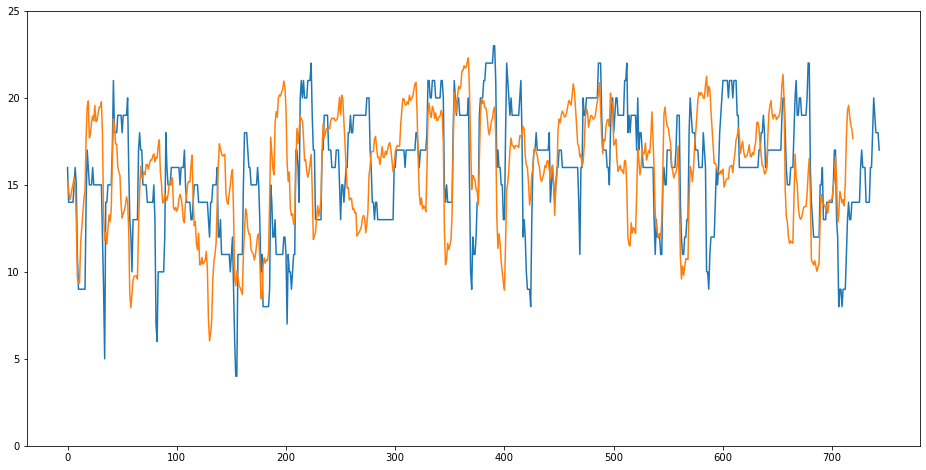

In [32]:
plt.figure(figsize=(16,8))
plt.ylim(0, 25)
#plt.plot(array)
plt.plot(train_df['bikes_available'].to_numpy().tolist() )
plt.plot(array)

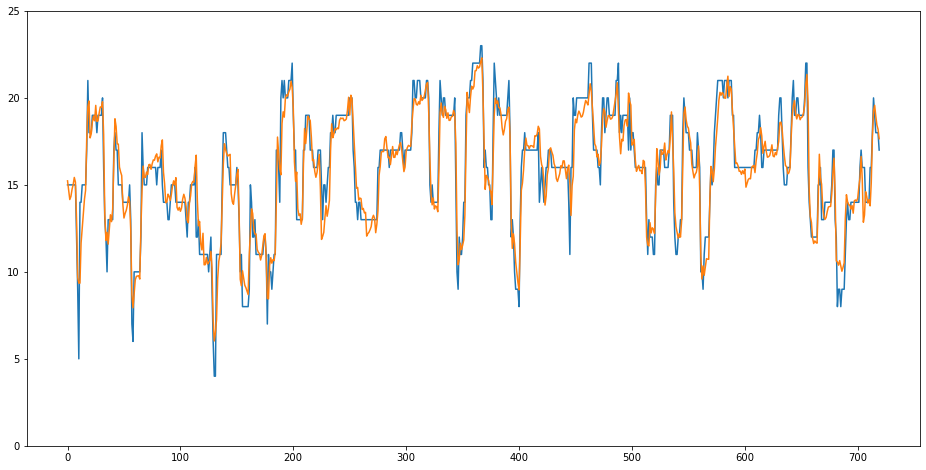

In [33]:
plt.figure(figsize=(16,8))
plt.ylim(0, 25)
plt.plot(array_bike)
plt.plot(array)

In [34]:
#predictは特徴量として必要ないため、削除
test = test.drop("predict",axis=1)
test

,date,hour,station_id,bikes_available,weekday_土曜日,weekday_日曜日,weekday_月曜日,weekday_木曜日,weekday_水曜日,weekday_火曜日,weekday_金曜日
1464,2013-11-01 00:00:00,0,0,17.0,0,0,0,0,0,0,1
1465,2013-11-01 01:00:00,1,0,16.0,0,0,0,0,0,0,1
1466,2013-11-01 02:00:00,2,0,16.0,0,0,0,0,0,0,1
1467,2013-11-01 03:00:00,3,0,16.0,0,0,0,0,0,0,1
1468,2013-11-01 04:00:00,4,0,16.0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...
1627,2013-11-07 19:00:00,19,0,18.0,0,0,0,1,0,0,0
1628,2013-11-07 20:00:00,20,0,16.0,0,0,0,1,0,0,0
1629,2013-11-07 21:00:00,21,0,16.0,0,0,0,1,0,0,0
1630,2013-11-07 22:00:00,22,0,16.0,0,0,0,1,0,0,0


In [35]:
#今回LSTMモデルを使用するため、データを標準化
#特徴量を標準化するための変数
scaler = MinMaxScaler(feature_range=(0, 1))
#標準化された出力をもとにスケールに変換(inverse)するために必要な変数
scaler_for_inverse = MinMaxScaler(feature_range=(0, 1))
test_df_scale = scaler.fit_transform(test.iloc[:,3:])
bikes_available_scale = scaler_for_inverse.fit_transform(test[["bikes_available"]])
print(test_df_scale.shape)

(168, 8)


In [36]:
#学習用のデータをモデルの学習用とモデルの精度の検証用に分割
#今回は、モデル用学習データ:精度用の検証データ = 7 : 3 に分割
length = len(test_df_scale)
test = test_df_scale[0:length,:]
print(test.shape)

(168, 8)


In [37]:
testX, testY = create_dataset(test)

In [38]:
#LSTMのモデルに入力用にデータの形を整形
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], testX.shape[2]))
#入力データと正解データの形を確認
print(testX.shape)
print(testY.shape)

(144, 8, 24)
(144, 1)


In [39]:
#学習済みモデルで予測
#train_predict = model.predict(trainX)
test_predict = model.predict(testX)

#スケールをもとに戻す
#train_predict = scaler_for_inverse.inverse_transform(train_predict)
#trainY = scaler_for_inverse.inverse_transform(trainY)
test_predict = scaler_for_inverse.inverse_transform(test_predict)
testY = scaler_for_inverse.inverse_transform(testY)

#各ステーションのスコアの平均値を算出
#train_score_list = []
test_score_list = []

#trainscore = math.sqrt(mean_squared_error(trainY[:,0], train_predict[:,0]))
#train_score_list.append(trainscore)
testscore = math.sqrt(mean_squared_error(testY[:,0], test_predict[:,0]))
test_score_list.append(testscore)
    
#print("trainのRMSE平均 : ",mean(train_score_list))
print("testのRMSE平均 : ",mean(test_score_list))

testのRMSE平均 :  2.168921778764681


In [40]:
testY

array([[19.],
       [19.],
       [19.],
       [19.],
       [18.],
       [19.],
       [19.],
       [19.],
       [19.],
       [19.],
       [18.],
       [18.],
       [18.],
       [18.],
       [16.],
       [16.],
       [16.],
       [15.],
       [16.],
       [16.],
       [16.],
       [16.],
       [15.],
       [16.],
       [16.],
       [17.],
       [ 0.],
       [17.],
       [17.],
       [17.],
       [16.],
       [16.],
       [17.],
       [17.],
       [17.],
       [18.],
       [18.],
       [18.],
       [18.],
       [18.],
       [18.],
       [18.],
       [16.],
       [17.],
       [17.],
       [17.],
       [17.],
       [16.],
       [16.],
       [16.],
       [16.],
       [16.],
       [16.],
       [16.],
       [17.],
       [19.],
       [16.],
       [13.],
       [12.],
       [11.],
       [11.],
       [11.],
       [10.],
       [10.],
       [11.],
       [14.],
       [15.],
       [15.],
       [13.],
       [13.],
       [14.],
      

In [41]:
array_true = []
for i in testY:
    array_true.append(i[0])
array_true

[19.0,
 19.0,
 19.0,
 19.0,
 18.0,
 19.0,
 19.0,
 19.0,
 19.0,
 19.0,
 18.0,
 18.0,
 18.0,
 18.0,
 16.0,
 16.0,
 16.0,
 15.000000000000002,
 16.0,
 16.0,
 16.0,
 16.0,
 15.000000000000002,
 16.0,
 16.0,
 17.0,
 0.0,
 17.0,
 17.0,
 17.0,
 16.0,
 16.0,
 17.0,
 17.0,
 17.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 18.0,
 16.0,
 17.0,
 17.0,
 17.0,
 17.0,
 16.0,
 16.0,
 16.0,
 16.0,
 16.0,
 16.0,
 16.0,
 17.0,
 19.0,
 16.0,
 12.999999999999998,
 12.0,
 11.000000000000002,
 11.000000000000002,
 11.000000000000002,
 10.0,
 10.0,
 11.000000000000002,
 14.0,
 15.000000000000002,
 15.000000000000002,
 12.999999999999998,
 12.999999999999998,
 14.0,
 14.0,
 12.999999999999998,
 12.999999999999998,
 12.999999999999998,
 12.999999999999998,
 12.999999999999998,
 14.0,
 15.000000000000002,
 15.000000000000002,
 12.999999999999998,
 9.0,
 9.0,
 6.0,
 6.0,
 6.0,
 5.0,
 6.0,
 6.0,
 9.0,
 11.000000000000002,
 12.0,
 10.0,
 9.0,
 9.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 8.0,
 9.0,
 10.0,
 8.0,
 7.0,


In [42]:
array_pred = []
for i in test_predict:
    array_pred.append(i[0])
array_pred

[16.692156,
 17.149422,
 17.258492,
 17.270077,
 17.285591,
 17.035103,
 17.115988,
 17.120934,
 17.69429,
 18.61054,
 17.536404,
 17.550522,
 17.12136,
 15.895134,
 15.237919,
 14.078448,
 13.994034,
 14.545274,
 14.142726,
 14.802487,
 14.705116,
 14.571215,
 14.822084,
 14.090296,
 14.13741,
 14.272764,
 14.774629,
 6.3379054,
 12.205425,
 14.301951,
 14.255577,
 15.169709,
 15.311771,
 15.021307,
 15.233193,
 15.526274,
 15.218884,
 15.481004,
 15.99025,
 15.754437,
 15.849735,
 16.9935,
 16.003296,
 15.810291,
 15.896497,
 15.934268,
 14.845186,
 15.959863,
 15.151205,
 15.172603,
 14.182834,
 15.537136,
 15.3548155,
 15.4867735,
 15.707706,
 16.207705,
 16.241112,
 14.753046,
 12.844807,
 12.544406,
 11.815575,
 11.516148,
 11.354558,
 10.496849,
 10.445207,
 12.92617,
 14.644596,
 14.742456,
 14.661427,
 13.740784,
 13.284307,
 13.818829,
 13.7071905,
 12.517207,
 12.6664295,
 13.174836,
 13.284149,
 13.871496,
 15.0960455,
 15.368827,
 13.571354,
 10.415104,
 8.383331,
 8.52111

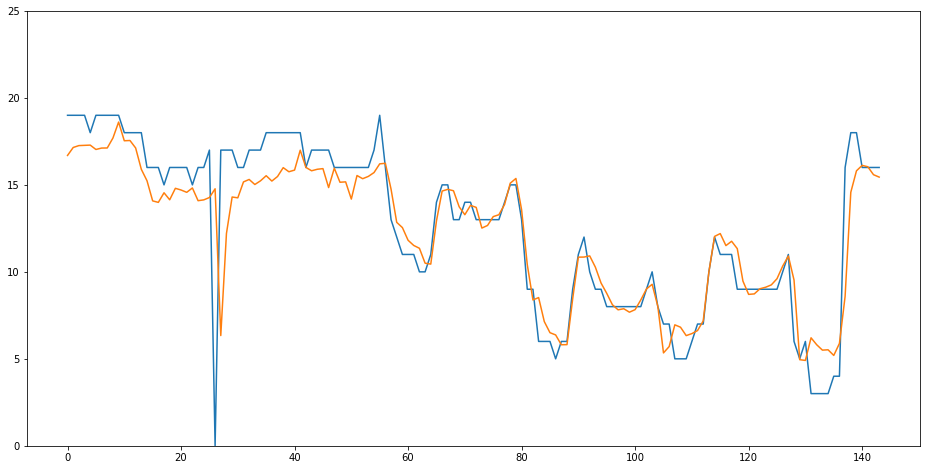

In [43]:
plt.figure(figsize=(16,8))
plt.ylim(0, 25)
plt.plot(array_true)
plt.plot(array_pred)